<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/AdaNorm_DoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
import torch.nn.functional as F

Original DoRA

In [ ]:
class DoRA(nn.Module):
    def __init__(self, w: nn.Module , lora_r= 1, lora_dropout = 0.0, lora_s = 1.0, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.weight = w.weight
        self.in_features = w.in_features
        self.out_features = w.out_features
        self.weight_m = nn.Parameter(self.weight.norm(p=2, dim=0, keepdim=True)) ###magnitude component
        self.lora_r = lora_r
        if w.bias is not None:
            self.bias = nn.Parameter(w.bias.clone())
        else:
            self.bias = None
        self.lora_A = nn.Parameter(w.weight.new_zeros((self.lora_r, self.in_features))) #####defining lora matrix A
        self.lora_B = nn.Parameter(w.weight.new_zeros((self.out_features, self.lora_r))) #####defining lora matrix B
        self.scaling = lora_s

        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, input: torch.Tensor) -> torch.Tensor:

        lora = (self.lora_A.T @ self.lora_B.T).T * self.scaling
        numerator = self.weight + lora
        denominator = torch.linalg.norm(numerator,dim=1).unsqueeze(1)
        directional_component = numerator / denominator
        weight = self.weight_m * directional_component
        return nn.functional.linear(input, weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}, lora_dim={}, lora_scale={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.lora_r, self.scaling
        )


class DoRAInitializer:
    def __init__(self, model, r=[14,14,12,12,10,10,8,8,8,8,8,8], lora=['q', 'v']):
        self.model = model
        self.r = r
        self.lora = lora
        self.w_As = []
        self.w_Bs = []
        self.initialize_dora()

    def initialize_dora(self):
        for param in self.model.backbone.parameters():
            param.requires_grad = False

        for t_layer_i, blk in enumerate(self.model.backbone.encoder.layer):
            dim = blk.attention.attention.query.in_features

            if 'q' in self.lora:
                w_q = blk.attention.attention.query
                blk.attention.attention.query = DoRA(w_q, lora_r = self.r[t_layer_i])

            if 'v' in self.lora:
                w_v = blk.attention.attention.value
                blk.attention.attention.value = DoRA(w_v, lora_r = self.r[t_layer_i])

            if 'k' in self.lora:
                w_k = blk.attention.attention.key
                blk.attention.attention.key = DoRA(w_k, lora_r = self.r[t_layer_i])

        # self.reset_parameters()
        print("DoRA params initialized!")

Adaptive Weight Normalization (AdaNorm)

In [2]:
import torch
import torch.nn as nn
import math

class AdaNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_features, **factory_kwargs))  # Learnable scale parameter
        self.shift = nn.Parameter(torch.zeros(num_features, **factory_kwargs))  # Learnable shift parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normalize the input (L2 normalization)
        norm = torch.norm(x, p=2, dim=1, keepdim=True)
        x_normalized = x / (norm + self.eps)

        # Apply adaptive scaling and shifting
        x_adanorm = self.scale * x_normalized + self.shift
        return x_adanorm


class DoRA(nn.Module):
    def __init__(self, w: nn.Module, lora_r=1, lora_dropout=0.0, lora_s=1.0, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.weight = w.weight
        self.in_features = w.in_features
        self.out_features = w.out_features
        self.weight_m = nn.Parameter(self.weight.norm(p=2, dim=0, keepdim=True))  # Magnitude component
        self.lora_r = lora_r

        if w.bias is not None:
            self.bias = nn.Parameter(w.bias.clone())
        else:
            self.bias = None

        self.lora_A = nn.Parameter(w.weight.new_zeros((self.lora_r, self.in_features)))  # LoRA matrix A
        self.lora_B = nn.Parameter(w.weight.new_zeros((self.out_features, self.lora_r)))  # LoRA matrix B
        self.scaling = lora_s

        # Initialize AdaNorm for the directional component
        self.adanorm = AdaNorm(self.out_features, device=device, dtype=dtype)

        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # Compute LoRA update
        lora = (self.lora_A.T @ self.lora_B.T).T * self.scaling

        # Combine original weight and LoRA update
        numerator = self.weight + lora

        # Apply AdaNorm to the directional component
        directional_component = self.adanorm(numerator)

        # Apply magnitude component
        weight = self.weight_m * directional_component

        return nn.functional.linear(input, weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}, lora_dim={}, lora_scale={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.lora_r, self.scaling
        )


class DoRAInitializer:
    def __init__(self, model, r=[14, 14, 12, 12, 10, 10, 8, 8, 8, 8, 8, 8], lora=['q', 'v']):
        self.model = model
        self.r = r
        self.lora = lora
        self.w_As = []
        self.w_Bs = []
        self.initialize_dora()

    def initialize_dora(self):
        # Freeze the backbone parameters
        for param in self.model.backbone.parameters():
            param.requires_grad = False

        # Apply DoRA to query, key, and value layers
        for t_layer_i, blk in enumerate(self.model.backbone.encoder.layer):
            dim = blk.attention.attention.query.in_features

            if 'q' in self.lora:
                w_q = blk.attention.attention.query
                blk.attention.attention.query = DoRA(w_q, lora_r=self.r[t_layer_i])

            if 'v' in self.lora:
                w_v = blk.attention.attention.value
                blk.attention.attention.value = DoRA(w_v, lora_r=self.r[t_layer_i])

            if 'k' in self.lora:
                w_k = blk.attention.attention.key
                blk.attention.attention.key = DoRA(w_k, lora_r=self.r[t_layer_i])

        print("DoRA params initialized!")

Dynamic Normalization DoRA
(https://arxiv.org/abs/2101.06073)

In [8]:
import torch
import torch.nn as nn
import math

class DynamicNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(num_features, **factory_kwargs))  # Learnable scale parameter
        self.shift = nn.Parameter(torch.zeros(num_features, **factory_kwargs))  # Learnable shift parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Compute mean and variance dynamically based on the input
        mean = x.mean(dim=1, keepdim=True)  # Mean over the feature dimension
        var = x.var(dim=1, keepdim=True)    # Variance over the feature dimension

        # Normalize the input using dynamic mean and variance
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)

        # Apply learnable scaling and shifting
        x_dynamic_norm = self.scale * x_normalized + self.shift
        return x_dynamic_norm


class DoRA(nn.Module):
    def __init__(self, w: nn.Module, lora_r=1, lora_dropout=0.0, lora_s=1.0, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.weight = w.weight
        self.in_features = w.in_features
        self.out_features = w.out_features
        self.weight_m = nn.Parameter(self.weight.norm(p=2, dim=0, keepdim=True))  # Magnitude component
        self.lora_r = lora_r

        if w.bias is not None:
            self.bias = nn.Parameter(w.bias.clone())
        else:
            self.bias = None

        self.lora_A = nn.Parameter(w.weight.new_zeros((self.lora_r, self.in_features)))  # LoRA matrix A
        self.lora_B = nn.Parameter(w.weight.new_zeros((self.out_features, self.lora_r)))  # LoRA matrix B
        self.scaling = lora_s

        # Initialize DynamicNorm for the directional component
        self.dynamic_norm = DynamicNorm(self.out_features, device=device, dtype=dtype)

        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # Compute LoRA update
        lora = (self.lora_A.T @ self.lora_B.T).T * self.scaling

        # Combine original weight and LoRA update
        numerator = self.weight + lora

        # Apply Dynamic Normalization to the directional component
        directional_component = self.dynamic_norm(numerator)

        # Apply magnitude component
        weight = self.weight_m * directional_component

        return nn.functional.linear(input, weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}, lora_dim={}, lora_scale={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.lora_r, self.scaling
        )


class DoRAInitializer:
    def __init__(self, model, r=[14, 14, 12, 12, 10, 10, 8, 8, 8, 8, 8, 8], lora=['q', 'v']):
        self.model = model
        self.r = r
        self.lora = lora
        self.w_As = []
        self.w_Bs = []
        self.initialize_dora()

    def initialize_dora(self):
        # Freeze the backbone parameters
        for param in self.model.backbone.parameters():
            param.requires_grad = False

        # Apply DoRA to query, key, and value layers
        for t_layer_i, blk in enumerate(self.model.backbone.encoder.layer):
            dim = blk.attention.attention.query.in_features

            if 'q' in self.lora:
                w_q = blk.attention.attention.query
                blk.attention.attention.query = DoRA(w_q, lora_r=self.r[t_layer_i])

            if 'v' in self.lora:
                w_v = blk.attention.attention.value
                blk.attention.attention.value = DoRA(w_v, lora_r=self.r[t_layer_i])

            if 'k' in self.lora:
                w_k = blk.attention.attention.key
                blk.attention.attention.key = DoRA(w_k, lora_r=self.r[t_layer_i])

        print("DoRA params initialized!")

In [9]:
class DepthAnythingDepthEstimationHead(nn.Module):

    def __init__(self, model_head):
        super().__init__()

        # self.head_in_index = config.head_in_index
        # self.patch_size = config.patch_size

        # features = config.fusion_hidden_size
        self.conv1 = model_head.conv1
        self.conv2 = model_head.conv2
        self.activation1 = nn.ReLU()
        self.conv3 = model_head.conv3
        self.activation2 = nn.Sigmoid()

    def forward(self, hidden_states, height, width):
        #hidden_states = hidden_states[self.head_in_index]#[1, 64, 144, 176]
        #print('Final Head:',hidden_states.shape)
        predicted_depth = self.conv1(hidden_states)
        predicted_depth = nn.functional.interpolate(
            predicted_depth,
            (int(height), int(width)),
            mode="bilinear",
            align_corners=True,
        )
        # print('head predicted_depth:', predicted_depth.shape)
        predicted_depth = self.conv2(predicted_depth)
        predicted_depth = self.activation1(predicted_depth)
        predicted_depth = self.conv3(predicted_depth)
        predicted_depth = self.activation2(predicted_depth)
        # predicted_depth = predicted_depth.squeeze(dim=1)  # shape (batch_size, height, width)

        return predicted_depth

In [10]:
class Customised_DAM(nn.Module):
    def __init__(self, r = [14,14,12,12,10,10,8,8,8,8,8,8], lora = ['q', 'v']):
        super(Customised_DAM, self).__init__()
        print("custom_DAM_separatedVectorLoRAinit")
        print("rank is:",r)
        model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
        self.r = r
        self.lora = lora
        self.config = model.config
        self.backbone = model.backbone

        # Initialize LoRA parameters

        self.dora_initializer = DoRAInitializer(model, r, lora)

        self.neck = model.neck
        model_head = model.head
        self.head = DepthAnythingDepthEstimationHead(model_head)
        model.post_init()

    def save_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.

        save both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        num_layer = len(self.w_As)  # actually, it is half
        a_tensors = {f"w_a_{i:03d}": self.w_As[i].weight for i in range(num_layer)}
        b_tensors = {f"w_b_{i:03d}": self.w_Bs[i].weight for i in range(num_layer)}
        decode_head_tensors = {}

        # save prompt encoder, only `state_dict`, the `named_parameter` is not permitted
        if isinstance(self.decode_head, torch.nn.DataParallel) or isinstance(self.decode_head, torch.nn.parallel.DistributedDataParallel):
            state_dict = self.decode_head.module.state_dict()
        else:
            state_dict = self.decode_head.state_dict()
        for key, value in state_dict.items():
            decode_head_tensors[key] = value

        merged_dict = {**a_tensors, **b_tensors, **decode_head_tensors}
        torch.save(merged_dict, filename)

        print('saved lora parameters to %s.' % filename)

    def load_parameters(self, filename: str, device: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.\

        load both lora and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        state_dict = torch.load(filename, map_location=device)

        for i, w_A_linear in enumerate(self.w_As):
            saved_key = f"w_a_{i:03d}"
            saved_tensor = state_dict[saved_key]
            w_A_linear.weight = Parameter(saved_tensor)

        for i, w_B_linear in enumerate(self.w_Bs):
            saved_key = f"w_b_{i:03d}"
            saved_tensor = state_dict[saved_key]
            w_B_linear.weight = Parameter(saved_tensor)

        decode_head_dict = self.decode_head.state_dict()
        decode_head_keys = decode_head_dict.keys()

        # load decode head
        decode_head_keys = [k for k in decode_head_keys]
        decode_head_values = [state_dict[k] for k in decode_head_keys]
        decode_head_new_state_dict = {k: v for k, v in zip(decode_head_keys, decode_head_values)}
        decode_head_dict.update(decode_head_new_state_dict)

        self.decode_head.load_state_dict(decode_head_dict)

        print('loaded lora parameters from %s.' % filename)

    def forward(self, pixel_values):
        outputs = self.backbone.forward_with_filtered_kwargs(
            pixel_values, output_hidden_states=None, output_attentions=None
        )
        hidden_states = outputs.feature_maps
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size
        hidden_states = self.neck(hidden_states, patch_height, patch_width)
        outputs = {}
        outputs[("disp", 0)] = self.head(hidden_states[3], height, width)
        outputs[("disp", 1)] = self.head(hidden_states[2], height/2, width/2)
        outputs[("disp", 2)] = self.head(hidden_states[1], height/4, width/4)
        outputs[("disp", 3)] = self.head(hidden_states[0], height/8, width/8)
        return outputs

In [11]:
from google.colab import drive
from PIL import Image
from torchvision import transforms
!gdown 1EI5FJFPDuoMnXK-TF-pK8yWQoIYqi9Fp

Downloading...
From: https://drive.google.com/uc?id=1EI5FJFPDuoMnXK-TF-pK8yWQoIYqi9Fp
To: /content/0000001656.png
100% 155k/155k [00:00<00:00, 108MB/s]


In [12]:
image = Image.open('/content/0000001656.png')
img_np = np.array(image)  # Convert to a NumPy array
img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0  # Convert to tensor and scale
img1 = img_tensor
img2 = img_tensor
img_cat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)),dim=0)
inputs = torch.cat((img_cat, img_cat),dim=0)
model_depth = Customised_DAM()
outputs = model_depth(inputs)

custom_DAM_separatedVectorLoRAinit
rank is: [14, 14, 12, 12, 10, 10, 8, 8, 8, 8, 8, 8]
DoRA params initialized!


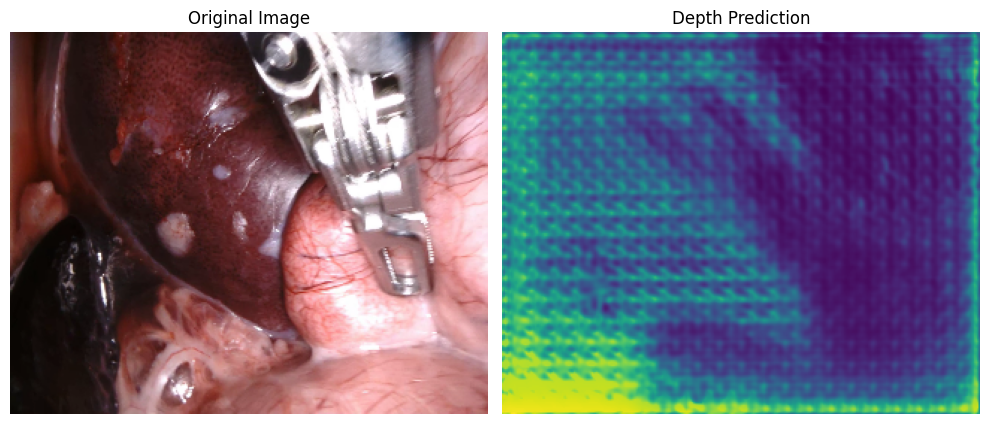

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize img1 for plotting
img1_np = img1.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and NumPy array
img1_np = np.clip(img1_np, 0, 1)  # Ensure values are in the range [0, 1]

# Get depth prediction and normalize it for plotting
depth_prediction = outputs[("disp", 0)][0].squeeze().detach().cpu().numpy()  # Remove channel dimension if present
depth_min = depth_prediction.min()
depth_max = depth_prediction.max()
depth_normalized = (depth_prediction - depth_min) / (depth_max - depth_min)  # Normalize to [0, 1]

# Plot side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img1_np)
plt.title("Original Image")
plt.axis("off")

# Depth prediction
plt.subplot(1, 2, 2)
plt.imshow(depth_normalized, cmap="viridis")  # Use a colormap for depth
plt.title("Depth Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()